In [5]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np
from tqdm import tqdm

BWGD Algorithm

In [6]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

# Returns the convergence count for errors for a set of test parameters
def convergence_counts(errors, parameter, error_threshold = 1e-8):
    zero_error = {}
    for i in range(len(errors)):
        zero_error[parameter[i]] = 0
        for error in errors[i]:
            zero_error[parameter[i]] += error[-1] < error_threshold
    return zero_error

In [7]:
def bwgd_smooth(y, A, niter=30, epsilon_rate="q", b=1.8, gamma=0.1):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Initialization
    lambda_sq = (1 / n) * np.sum(y**2)
    lambda_val = np.sqrt(lambda_sq)
    Y = (1 / n) * (A_tilde @ np.diag((1/np.sqrt(3) - np.exp(-y**2 / lambda_sq)) ) @ A_tilde.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)
    eigenvect = eigenvects[:, index]
    x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
    x[0] = C_inv @ x_tilde

    for iter in range(1, niter):
        # Dynamic epsilon decay
        if epsilon_rate == "1/k":
            epsilon = 1 / (iter + 1)  # Decaying epsilon as 1/k
        elif epsilon_rate == "2^-k":
            epsilon = 2**(-iter)  # Decaying epsilon as 2^-k
        elif epsilon_rate == "2^-b^k":
            epsilon = 2**(-b**iter)  # Decaying epsilon as 2^-b^k with b > 1
        elif epsilon_rate == "q":
            loss_values = (np.abs(A_tilde.T @ x_tilde) - y) ** 2
            epsilon = np.quantile(loss_values, gamma)
        else:
            raise ValueError("Unsupported epsilon rate function")

        # Compute values
        row_norms = np.sum(A_tilde**2, axis=0)
        numerator = np.sqrt(y**2 + epsilon * row_norms)
        denominator = np.sqrt(np.sum(A_tilde * ((np.outer(x_tilde,x_tilde) + epsilon * np.eye(d)) @ A_tilde), axis=0))
        alpha = numerator / denominator 

        # Update rule in matrix form
        x_tilde = (1/n) * A_tilde @ (alpha * (A_tilde.T @ x_tilde))
        
        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-15:
            return x[:iter]

    return x

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:10<00:00, 35.45s/it]


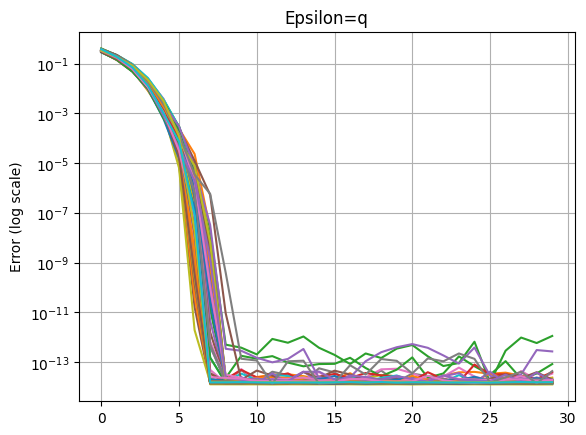

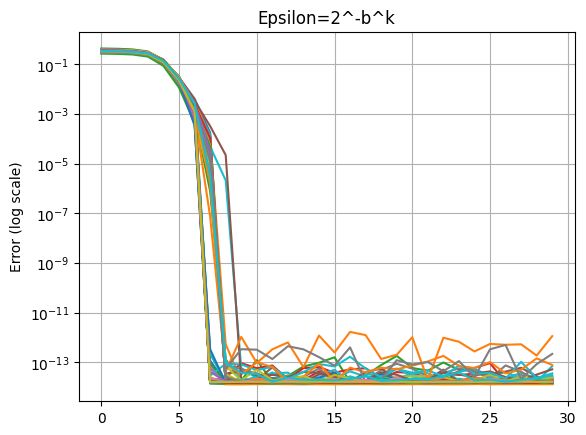

In [11]:
# Plot for d
errors = []
epsilons = ["q", "2^-b^k"]

d = 200
n = int(d * np.log(d))

for epsilon in tqdm(epsilons):
    error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.abs(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_smooth(y, A, epsilon_rate=epsilon)
        error.append(min_error(x_hat, x))  

    errors.append(error)

convergence_counts(errors, epsilons)

for i in range(len(errors)):
    for j in range(len(errors[i])):
        plt.plot(errors[i][j])
        plt.yscale('log')  
        plt.title(f'Epsilon={epsilons[i]}')
        plt.ylabel("Error (log scale)")
        plt.yscale('log')  
        plt.grid(True)
    plt.show()

Varying b

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:14<00:00, 38.92s/it]


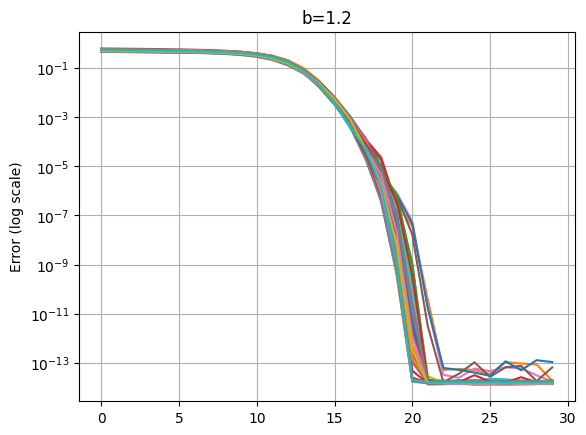

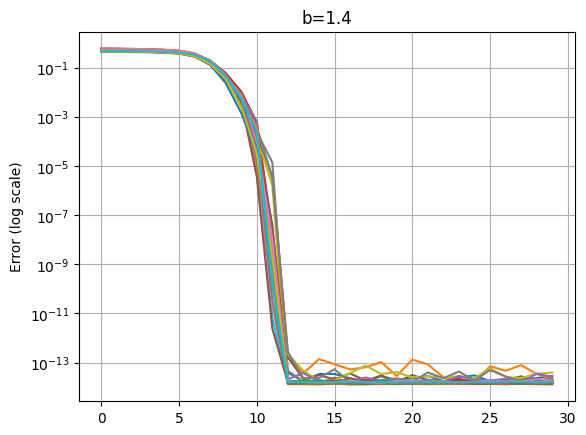

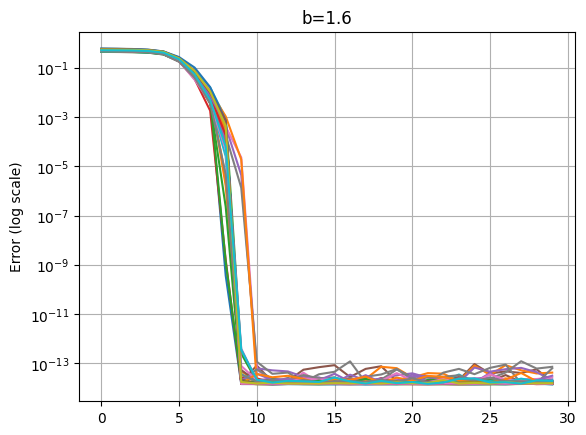

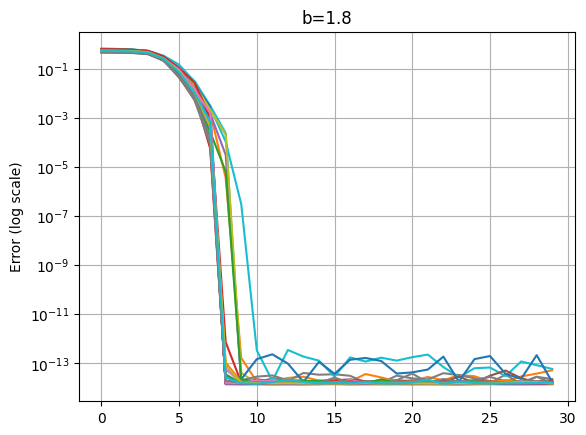

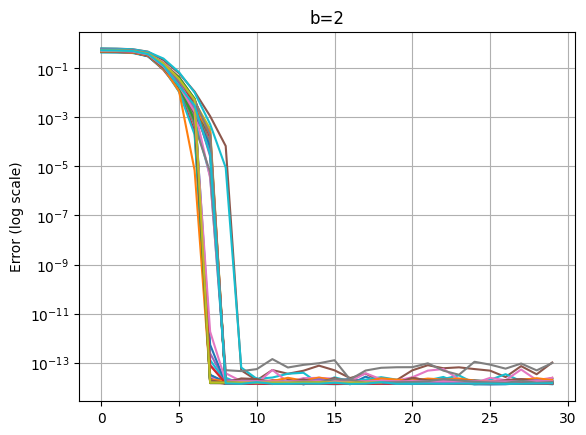

In [184]:
# Plot for d
errors = []
b = [1.2, 1.4, 1.6, 1.8, 2]
d = 200
n = int(d * np.log(d))

for bi in tqdm(b):
    error = []
    for j in range(1, 51):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.abs(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_smooth(y, A, b = bi)
        error.append(min_error(x_hat, x))  

    errors.append(error)

convergence_counts(errors, b)

for i in range(len(errors)):
    for j in range(len(errors[i])):
        plt.plot(errors[i][j])
        plt.yscale('log')  
        plt.title(f'b={b[i]}')
        plt.ylabel("Error (log scale)")
        plt.yscale('log')  
        plt.grid(True)
    plt.show()

In [14]:
# Plot for d
errors = []
gammas = [0.005, 0.01, 0.05, 0.1, 0.2, 0.4]
d = 200
n = int(d * np.log(d))

for gamma in tqdm(gammas):
    error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.abs(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_smooth(y, A, gamma = gamma)
        error.append(min_error(x_hat, x))  

    errors.append(error)

convergence_counts(errors, gammas)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:40<00:00, 66.71s/it]


{0.005: 100, 0.01: 100, 0.05: 100, 0.1: 100, 0.2: 100, 0.4: 61}

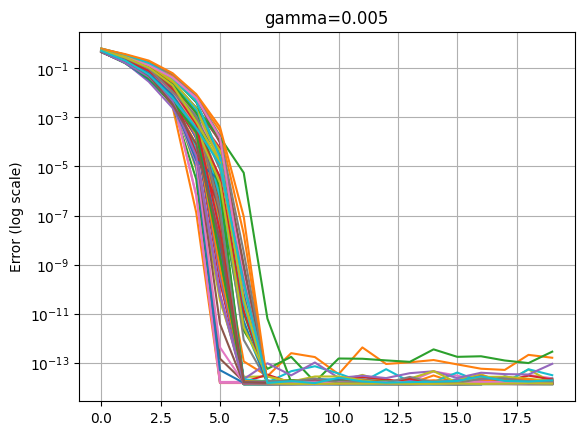

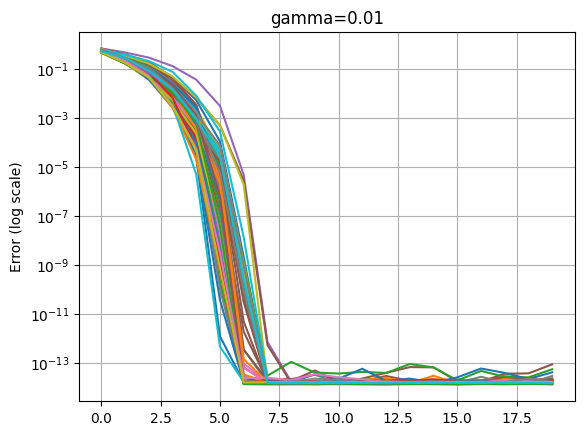

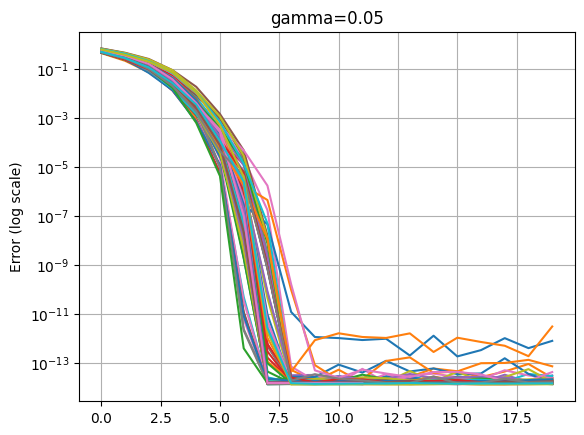

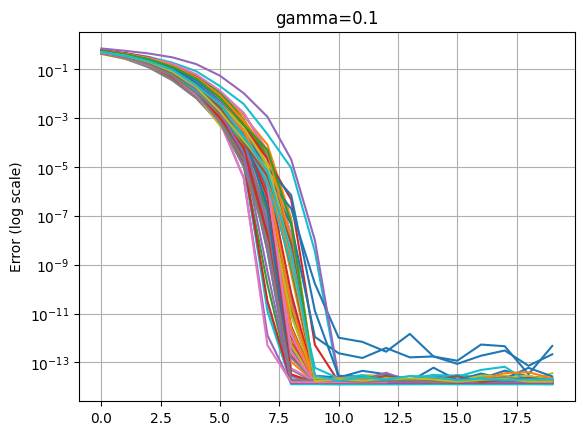

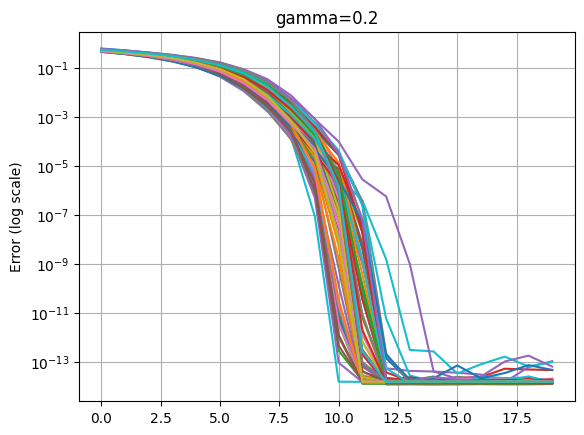

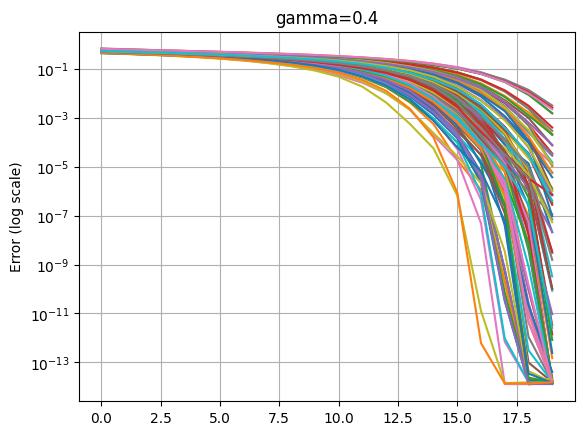

In [15]:
for i in range(len(errors)):
    for j in range(len(errors[i])):
        plt.plot(errors[i][j])
        plt.yscale('log')  
        plt.title(f'gamma={gammas[i]}')
        plt.ylabel("Error (log scale)")
        plt.yscale('log')  
        plt.grid(True)
    plt.show()

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

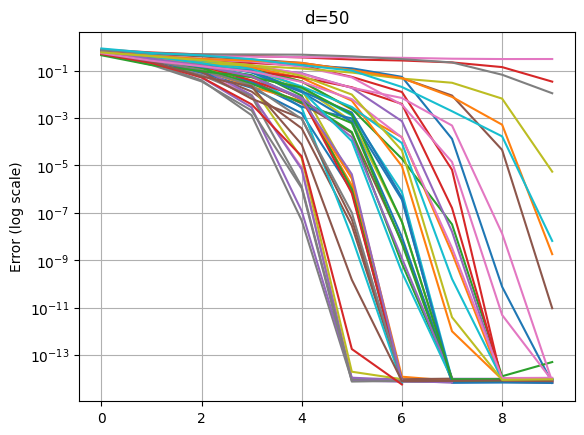

 17%|██████████████                                                                      | 1/6 [00:01<00:08,  1.67s/it]

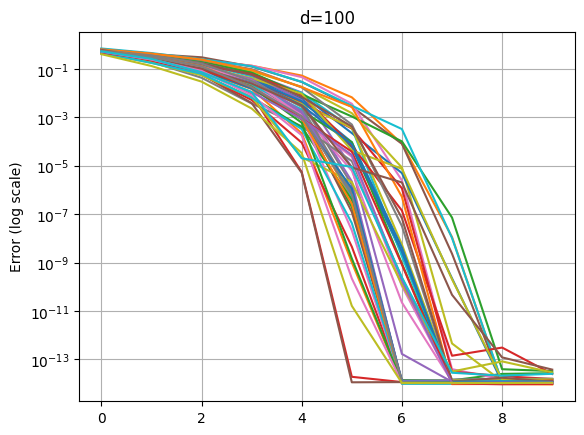

 33%|████████████████████████████                                                        | 2/6 [00:07<00:16,  4.08s/it]

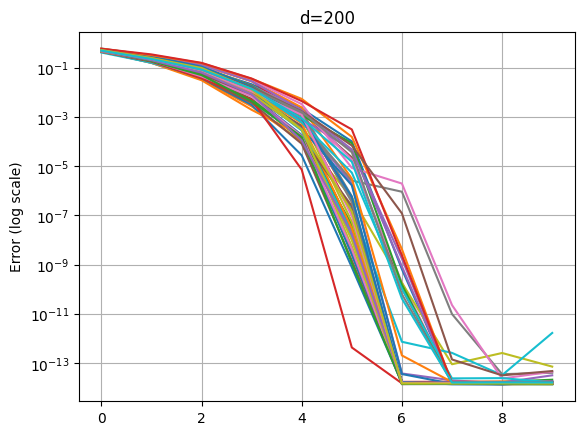

 50%|██████████████████████████████████████████                                          | 3/6 [00:32<00:40, 13.64s/it]

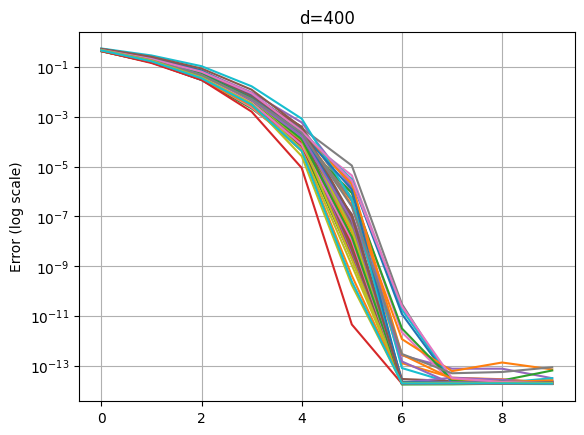

 67%|████████████████████████████████████████████████████████                            | 4/6 [02:32<01:51, 55.70s/it]

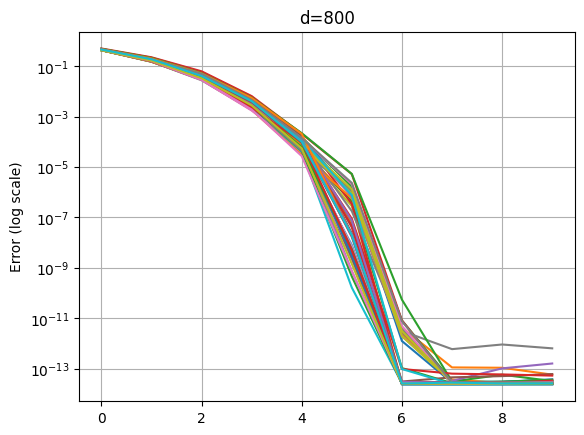

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [13:17<04:28, 268.08s/it]

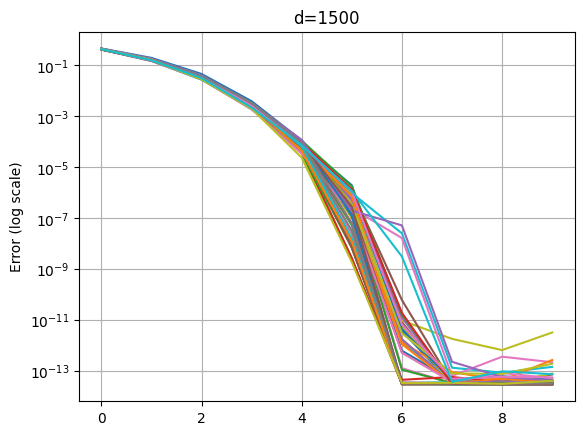

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:17:50<00:00, 778.36s/it]


{50: 46, 100: 50, 200: 50, 400: 50, 800: 50, 1500: 50}

In [19]:
# Plot for d
errors = []
ds = [50, 100, 200, 400, 800, 1500]

for d in tqdm(ds):
    error = []
    for j in range(1, 51):  
        n = int(d * np.log(d))
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.abs(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_smooth(y, A, niter = 10, gamma = 0.01)
        error.append(min_error(x_hat, x))
        plt.plot(error[j-1])
    plt.yscale('log')  
    plt.title(f'd={d}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.show()

    errors.append(error)

convergence_counts(errors, ds)

**Simple Gradient**

In [196]:
def gradient_smooth(y, A, niter=30, epsilon_rate="2^-b^k", b=1.8):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Spectral initialization
    Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)
    x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
    x[0] = C_inv @ x_tilde

    for iter in range(1, niter):
        # Dynamic epsilon decay
        if epsilon_rate == "1/k":
            epsilon = 1 / (iter + 1)  # Decaying epsilon as 1/k
        elif epsilon_rate == "2^-k":
            epsilon = 2**(-iter)  # Decaying epsilon as 2^-k
        elif epsilon_rate == "2^-b^k":
            epsilon = 2**(-b**iter)  # Decaying epsilon as 2^-b^k with b > 1
        else:
            raise ValueError("Unsupported epsilon rate function")

        # Descent
        right_gradient = A_tilde @ (np.sqrt(y + epsilon**2) * (A_tilde.T @ x_tilde) / np.sqrt((A_tilde.T @ x_tilde)**2 + epsilon**2))
        grad = (1 / n) * (x_tilde @ A_tilde @ A_tilde.T - right_gradient)
        x_tilde = x_tilde - grad

        x[iter] = C_inv @ x_tilde
        
        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-15:
            return x[:iter]

    return x

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:41<00:00, 13.84s/it]


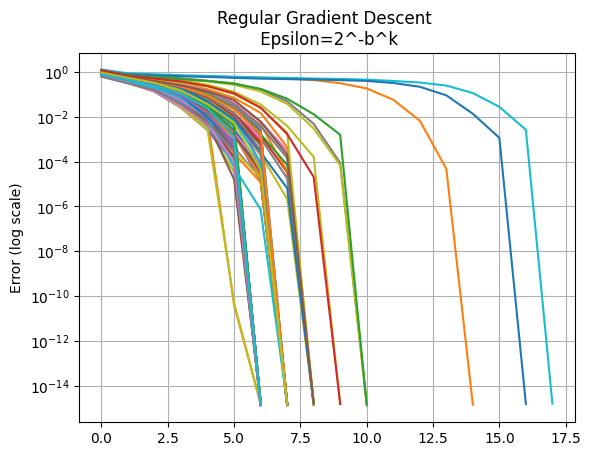

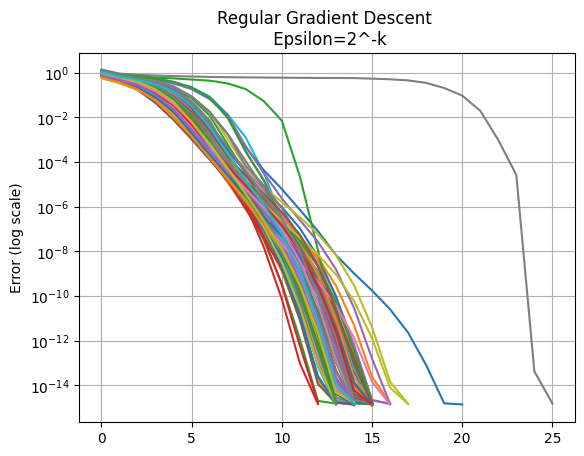

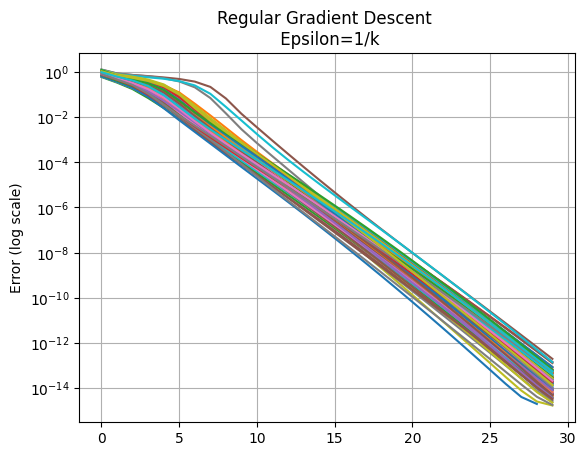

In [187]:
# Plot for d
errors = []
epsilons = ["2^-b^k", "2^-k", "1/k"]

d = 200
n = int(d * np.log(d))

for epsilon in tqdm(epsilons):
    error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = gradient_smooth(y, A, epsilon_rate=epsilon)
        error.append(min_error(x_hat, x))  

    errors.append(error)

convergence_counts(errors, epsilons)

for i in range(len(errors)):
    for j in range(len(errors[i])):
        plt.plot(errors[i][j])
        plt.yscale('log')  
        plt.title(f'Regular Gradient Descent \n Epsilon={epsilons[i]}')
        plt.ylabel("Error (log scale)")
        plt.yscale('log')  
        plt.grid(True)
    plt.show()

In [198]:
def scaled_gradient_smooth(y, A, niter=30, epsilon_rate="2^-b^k", b=1.8):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Spectral initialization
    Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)
    x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
    x[0] = C_inv @ x_tilde

    for iter in range(1, niter):
        # Dynamic epsilon decay
        if epsilon_rate == "1/k":
            epsilon = 1 / (iter + 1)  # Decaying epsilon as 1/k
        elif epsilon_rate == "2^-k":
            epsilon = 2**(-iter)  # Decaying epsilon as 2^-k
        elif epsilon_rate == "2^-b^k":
            epsilon = 2**(-b**iter)  # Decaying epsilon as 2^-b^k with b > 1
        else:
            raise ValueError("Unsupported epsilon rate function")

        # Compute squared norm of each row of A
        norm_sq = np.sum(A_tilde**2, axis=0) 
        epsilon_sq_scaled = norm_sq * epsilon**2  

        # Descent
        sqrt_term = np.sqrt((A_tilde.T @ x_tilde)**2 + epsilon_sq_scaled)
        right_gradient = A_tilde @ (np.sqrt(y + epsilon_sq_scaled) * (A_tilde.T @ x_tilde) / sqrt_term)
        grad = (1 / n) * (x_tilde @ A_tilde @ A_tilde.T - right_gradient)
        x_tilde = x_tilde - grad

        x[iter] = C_inv @ x_tilde
        
        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-15:
            return x[:iter]

    return x

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.67s/it]


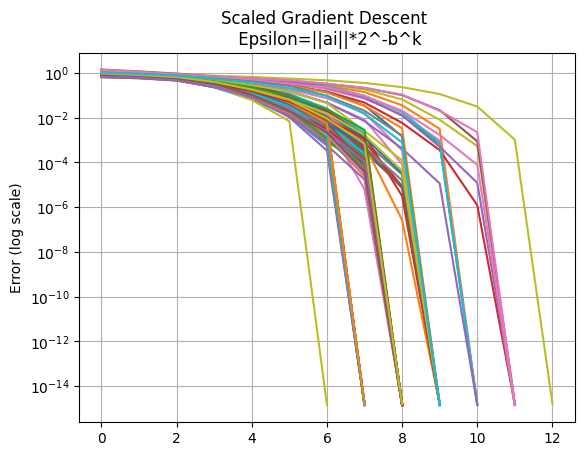

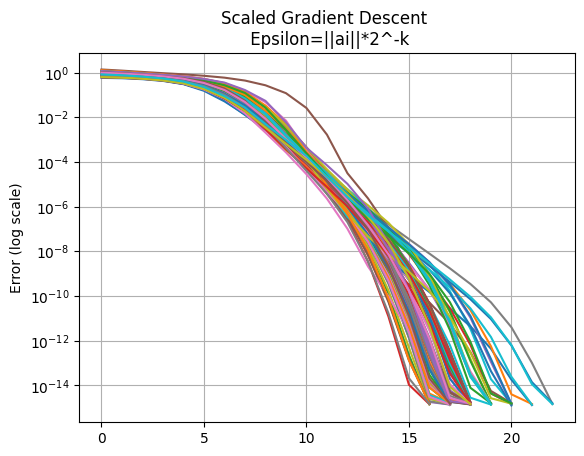

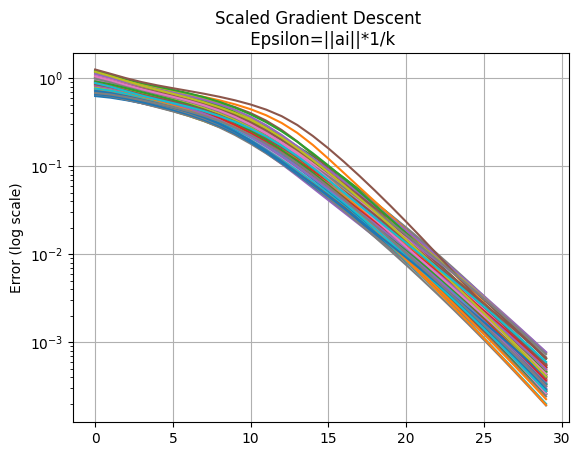

{'2^-b^k': 100, '2^-k': 100, '1/k': 0}

In [201]:
# Plot for d
errors = []
epsilons = ["2^-b^k", "2^-k", "1/k"]

d = 200
n = int(d * np.log(d))

for epsilon in tqdm(epsilons):
    error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = scaled_gradient_smooth(y, A, epsilon_rate=epsilon)
        error.append(min_error(x_hat, x))  

    errors.append(error)

for i in range(len(errors)):
    for j in range(len(errors[i])):
        plt.plot(errors[i][j])
        plt.yscale('log')  
        plt.title(f'Scaled Gradient Descent \n Epsilon=||ai||*{epsilons[i]}')
        plt.ylabel("Error (log scale)")
        plt.yscale('log')  
        plt.grid(True)
    plt.show()
convergence_counts(errors, epsilons)


Newton

In [193]:
def newton_smooth(y, A, niter=30, epsilon_rate="2^-b^k", b=1.8):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Spectral initialization
    Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)
    x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
    x[0] = C_inv @ x_tilde

    for iter in range(1, niter):
        # Dynamic epsilon decay
        if epsilon_rate == "1/k":
            epsilon = 1 / (iter + 1)  # Decaying epsilon as 1/k
        elif epsilon_rate == "2^-k":
            epsilon = 2**(-iter)  # Decaying epsilon as 2^-k
        elif epsilon_rate == "2^-b^k":
            epsilon = 2**(-b**iter)  # Decaying epsilon as 2^-b^k with b > 1
        else:
            raise ValueError("Unsupported epsilon rate function")

        # Gradient
        right_gradient = A_tilde @ (np.sqrt(y + epsilon**2) * (A_tilde.T @ x_tilde) / np.sqrt((A_tilde.T @ x_tilde)**2 + epsilon**2))
        grad = (1 / n) * (x_tilde @ A_tilde @ A_tilde.T - right_gradient)

        # Hessian
        A_x = A_tilde.T @ x_tilde  # Shape (n,)
        scaling_factors = np.sqrt(y + epsilon**2) / np.sqrt(A_x**2 + epsilon**2)
        H = (A_tilde @ A_tilde.T) / n + A_tilde @ (np.diag(scaling_factors) @ A_tilde.T) / n - A_tilde @ (np.diag(scaling_factors * (A_x**2 / (A_x**2 + epsilon**2))) @ A_tilde.T) / n        

        # Newton
        x_tilde = x_tilde - np.linalg.solve(H, grad)

        x[iter] = C_inv @ x_tilde
        
        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-15:
            return x[:iter]

    return x

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:28<00:00, 89.51s/it]


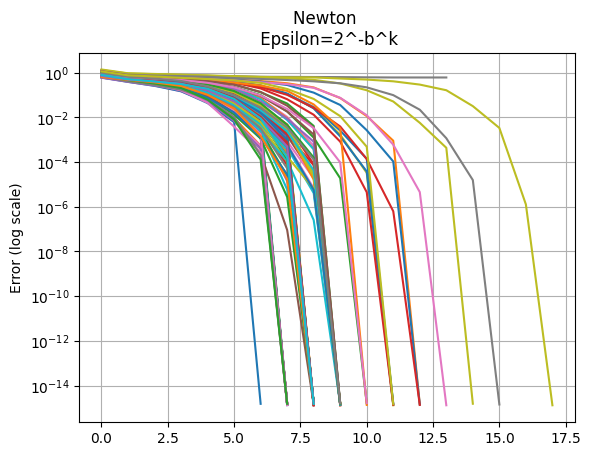

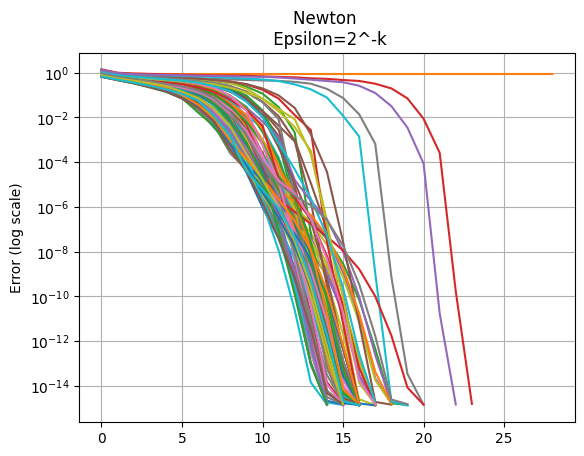

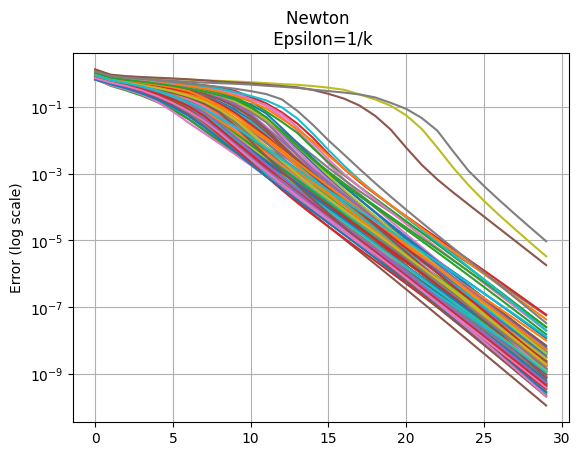

In [195]:
# Plot for d
errors = []
epsilons = ["2^-b^k", "2^-k", "1/k"]

d = 200
n = int(d * np.log(d))

for epsilon in tqdm(epsilons):
    error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)/np.sqrt(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = newton_smooth(y, A, epsilon_rate=epsilon)
        error.append(min_error(x_hat, x))  

    errors.append(error)

convergence_counts(errors, epsilons)

for i in range(len(errors)):
    for j in range(len(errors[i])):
        plt.plot(errors[i][j])
        plt.yscale('log')  
        plt.title(f'Newton \n Epsilon={epsilons[i]}')
        plt.ylabel("Error (log scale)")
        plt.yscale('log')  
        plt.grid(True)
    plt.show()